# デジタルフィルタの設計

Moodleから波形データファイルex2022.wavをダウンロードせよ。
ディジタルフィルタを以下の手順に従って設計せよ。
- 組み込み関数fft()を用いて、ex2022.wavの周波数スペクトルを求めよ。
- 周波数スペクトルからピーク周波数f1～f3 (f1<f2<f3)を特定せよ。
- f2近辺のみを阻止し、f1, f3を通過するフィルタを設計せよ。
- FIR, IIRいずれでもよいが、フィルタの次数が少ないものが望ましい。
- 波形へのフィルタの適用はflts()関数を用いればよい。

## wavファイルの読み込み

channel num    : 1
sample width   : 2
frame num      : 88200
frame rate     : 22050
comperess type : not compressed


/tmp/ipykernel_12721/1534465261.py:30: RuntimeWarning: divide by zero encountered in log10
  plt.plot(time/1e-3, 10*np.log10(np.abs(data)))


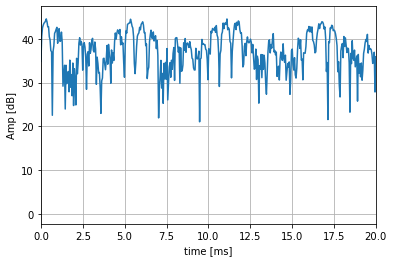

In [11]:
import wave
import numpy as np
import matplotlib.pyplot as plt

file_name = "ex2022.wav"
# file_name = "output.wav"


wf = wave.open(file_name , "r" )
buf = wf.readframes(wf.getnframes())
fs = wf.getframerate()

print("channel num    : {}".format(wf.getnchannels()))
print("sample width   : {}".format(wf.getsampwidth()))
print("frame num      : {}".format(wf.getnframes()))
print("frame rate     : {}".format(wf.getframerate()))
print("comperess type : {}".format(wf.getcompname()))

# バイナリデータを整数型（16bit）に変換
data = np.frombuffer(buf, dtype="int16")

n = data.size 

time = np.linspace(0, 1/fs * n, n)

# グラフ化
plt.xlabel("time [ms]")
plt.ylabel("Amp [dB]")
plt.xlim(0, 20)
plt.plot(time/1e-3, 10*np.log10(np.abs(data)))
plt.grid()
plt.show()

wf.close()

## FFT

f_1 = 523.0 Hz
f_2 = 698.0 Hz
f_3 = 880.0 Hz


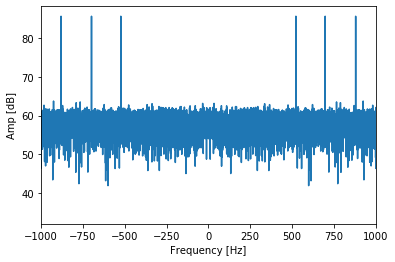

In [12]:
F = np.fft.fft(data)
F = np.abs(F)

freq = np.fft.fftfreq(F.size, 1/fs)

idx = np.where(F > 3e8)[0]

print("f_1 = {} Hz".format(np.take(freq, idx)[0]))
print("f_2 = {} Hz".format(np.take(freq, idx)[1]))
print("f_3 = {} Hz".format(np.take(freq, idx)[2]))

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amp [dB]")
plt.xlim(-1e3, 1e3)
plt.plot(freq, 10*np.log10(F))
plt.show()

## Band Stop Filter

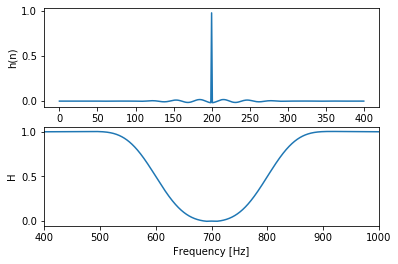

In [13]:
from scipy import signal

ntap = 400 + 1 # filter oder + 1

## cutoff freq
fc1 = 600 # Hz
fc2 = 800 # Hz

wfir = signal.firwin(ntap, [fc1, fc2], fs=fs)

H = np.fft.fft(np.pad(wfir, (0, n-ntap), mode='constant'))
H = np.abs(H)

plt.subplot(2,1,1)
plt.xlabel("n")
plt.ylabel("h(n)")
plt.plot(wfir)

plt.subplot(2,1,2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("H")
plt.xlim(400,1000)
plt.plot(freq[:int(n/2)], H[:int(n/2)])

plt.show()


## Apply Filter

In [14]:
from scipy.io import wavfile

filtered = signal.lfilter(wfir, 1, data)

wavfile.write("output.wav", fs, filtered.astype(np.int16))

## Compare Result

/tmp/ipykernel_12721/3569347211.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(time/1e-3, 10*np.log10(np.abs(data)),     label="raw")


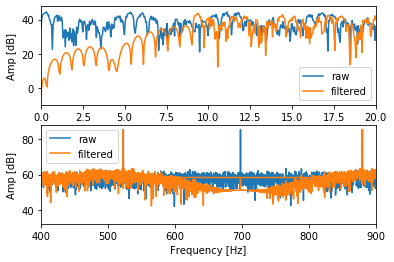

In [15]:
F2 = np.fft.fft(filtered)
F2 = np.abs(F2)


plt.subplot(2,1,1)
plt.xlabel("time [ms]")
plt.ylabel("Amp [dB]")
plt.xlim(0, 20)
plt.plot(time/1e-3, 10*np.log10(np.abs(data)),     label="raw")
plt.plot(time/1e-3, 10*np.log10(np.abs(filtered)), label="filtered")
plt.legend()

plt.subplot(2,1,2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amp [dB]")
plt.xlim(400, 900)
plt.plot(freq, 10*np.log10(F), label="raw")
plt.plot(freq, 10*np.log10(F2), label="filtered")
plt.legend()

plt.show()